✅ All imports successful!
ML Configuration loaded!
Target column: no_show
Primary metric: roc_auc
Data shape: (110527, 52)

Target distribution:
no_show
0    0.798
1    0.202
Name: proportion, dtype: float64
TARGET VARIABLE ANALYSIS

Target: no_show
Class distribution:
no_show
0    88208
1    22319
Name: count, dtype: int64

Class imbalance ratio: 1:4.0
FEATURE AVAILABILITY CHECK

Numeric features: 8/8
  Available: ['age', 'lead_days', 'patient_total_appointments', 'patient_previous_noshows', 'patient_historical_noshow_rate', 'neighborhood_noshow_rate', 'neighborhood_avg_age', 'schedule_hour']

Categorical features: 6/6
  Available: ['gender', 'age_group', 'lead_time_category', 'appointment_weekday', 'neighborhood_risk', 'health_risk_category']

Binary features: 16/16
  Available: ['scholarship', 'hypertension', 'diabetes', 'alcoholism', 'sms_received', 'is_first_appointment', 'is_monday', 'is_friday', 'is_weekend', 'has_chronic_condition', 'has_disability', 'young_long_lead', 'monday_

    ⚠️ Potential overfitting (gap: 0.1272)



📊 Model Comparison (Cross-Validation Results):
              model  roc_auc_mean  roc_auc_std  f1_mean   f1_std  precision_mean  precision_std  recall_mean  recall_std  accuracy_mean  accuracy_std
  gradient_boosting      0.743628     0.002959 0.134177 0.006543        0.603159       0.033328     0.075497    0.003747       0.803259      0.001540
            xgboost      0.743039     0.002962 0.456634 0.004387        0.322475       0.003395     0.781966    0.006815       0.624196      0.004044
      random_forest      0.741289     0.003641 0.454587 0.003637        0.319489       0.002895     0.787679    0.005880       0.618315      0.003771
logistic_regression      0.733800     0.001848 0.448738 0.003049        0.313008       0.002375     0.792327    0.005110       0.606892      0.003178
      decision_tree      0.727605     0.004279 0.447614 0.004946        0.309343       0.009777     0.812714    0.035272       0.594554      0.024796

📊 Test Set Performance:
              Model  Accura

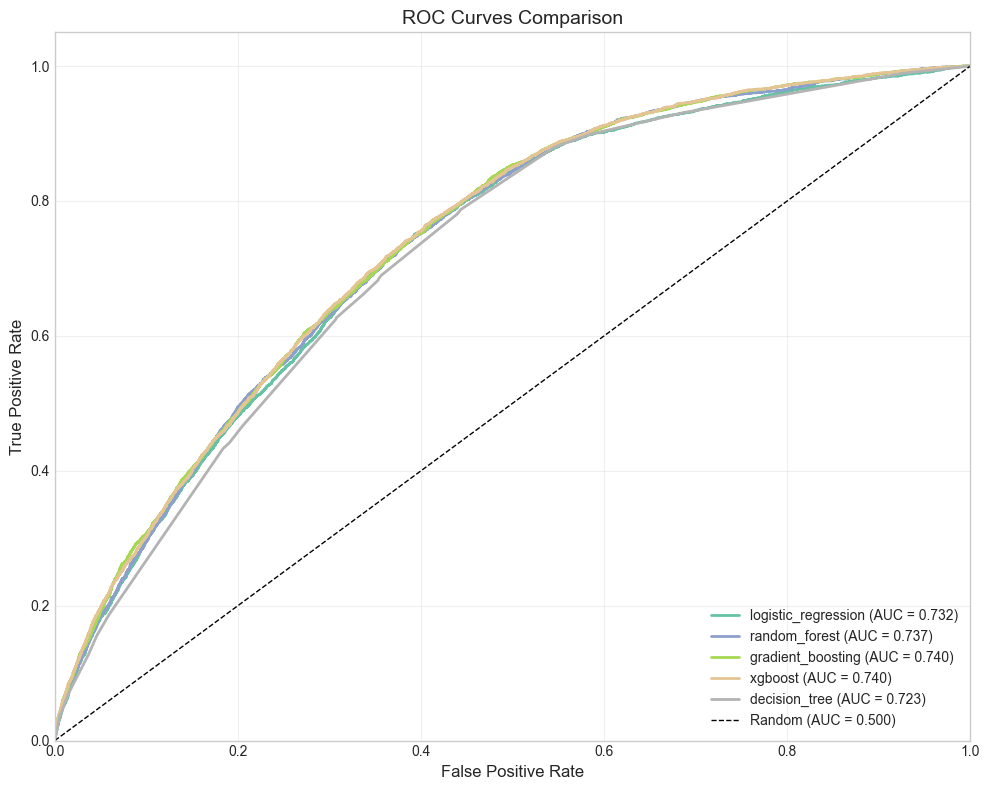

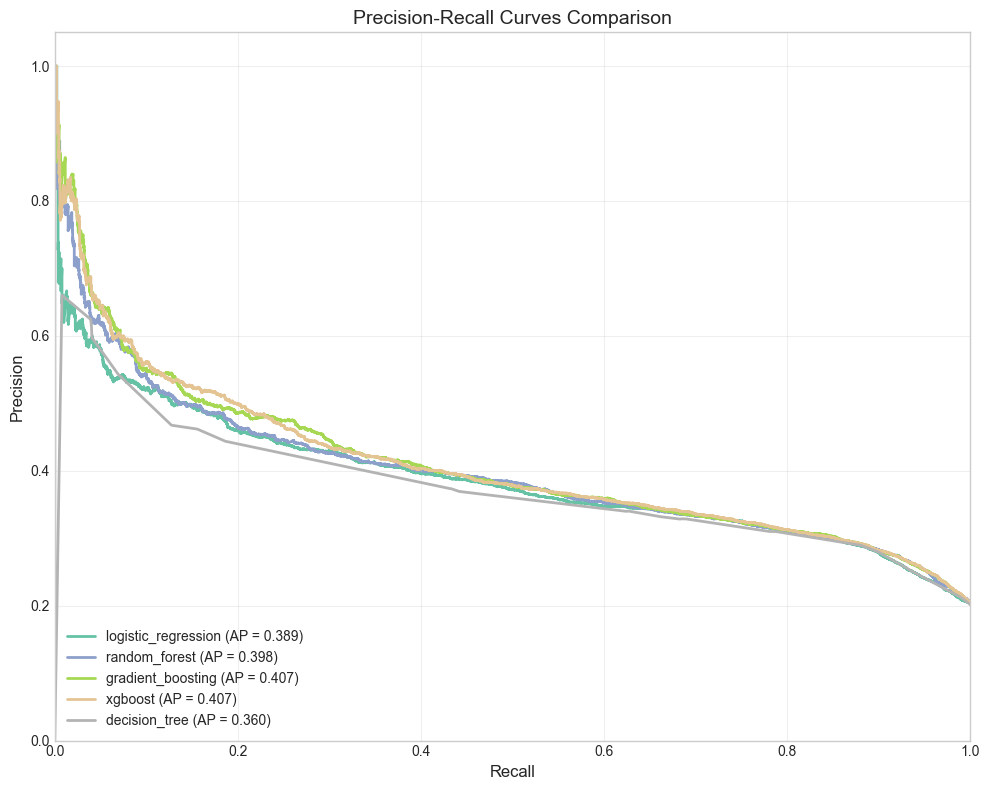

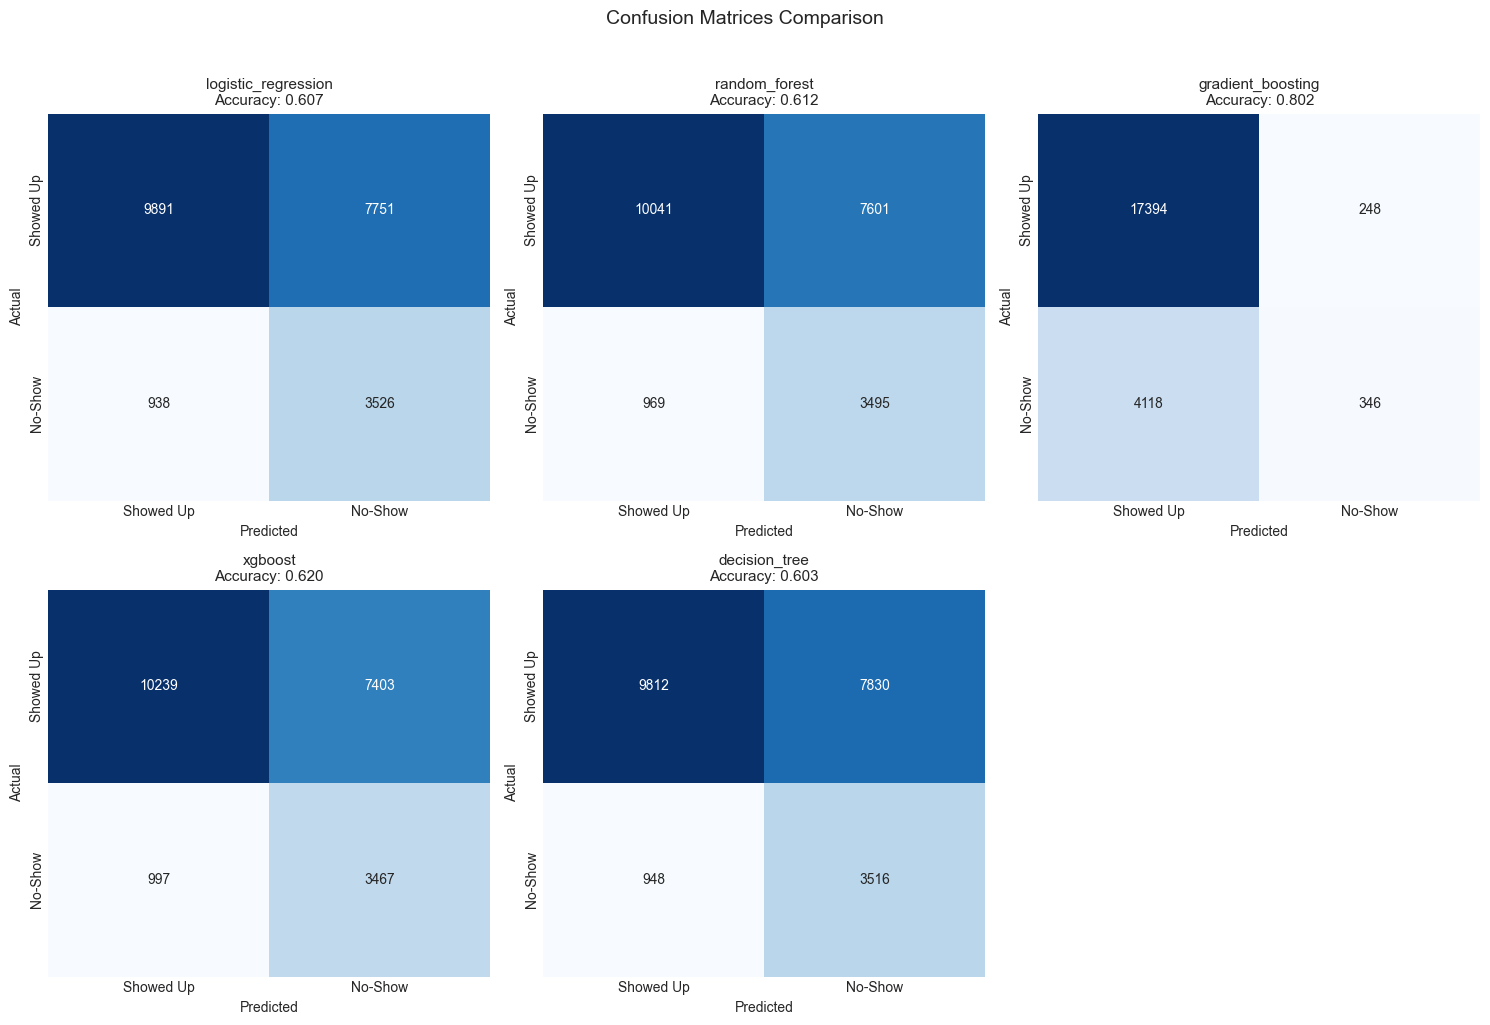

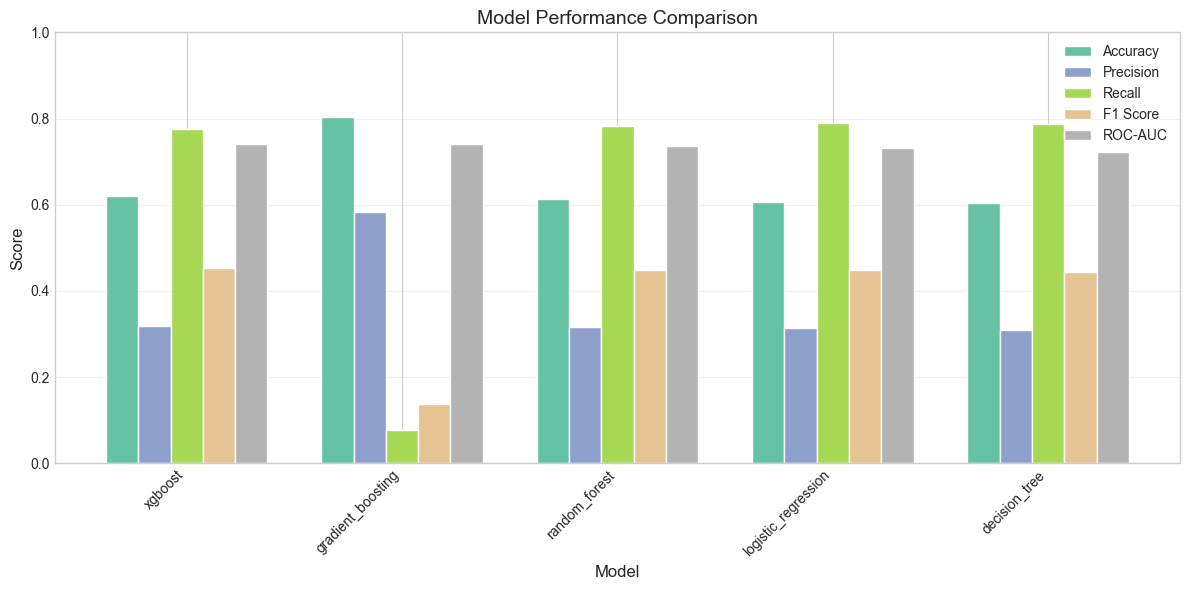

Best model: gradient_boosting


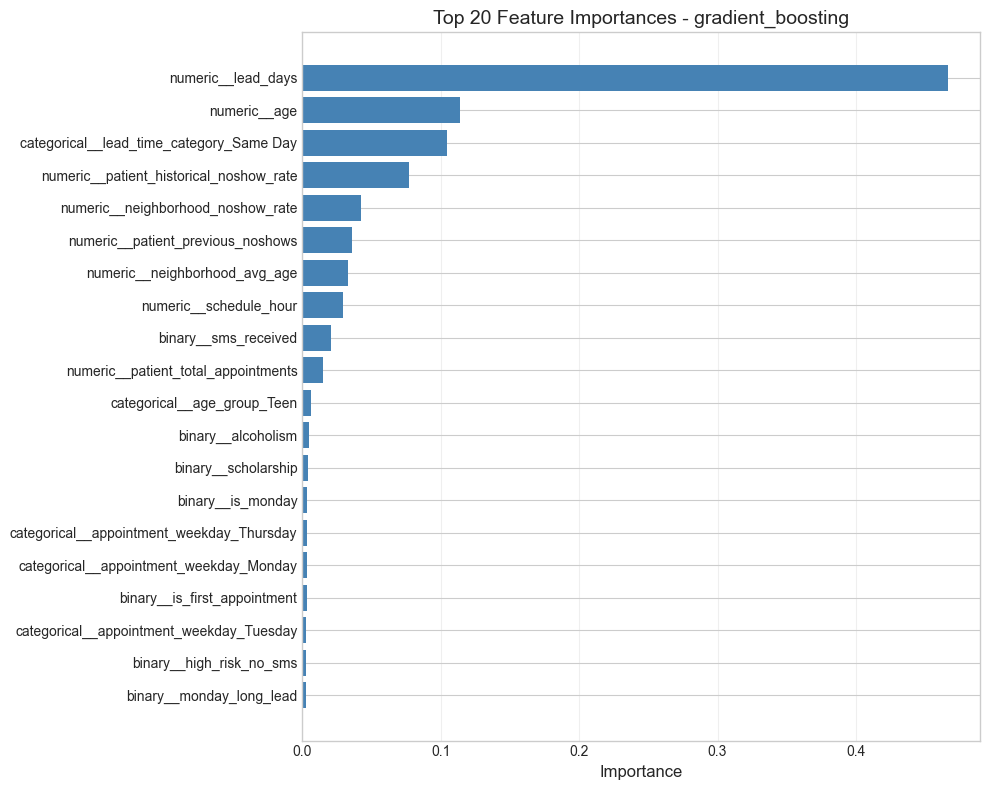


🔝 Top 10 Most Important Features (gradient_boosting):
                                 feature  importance
                      numeric__lead_days    0.466343
                            numeric__age    0.113773
categorical__lead_time_category_Same Day    0.104742
 numeric__patient_historical_noshow_rate    0.076804
       numeric__neighborhood_noshow_rate    0.042115
       numeric__patient_previous_noshows    0.035689
           numeric__neighborhood_avg_age    0.032736
                  numeric__schedule_hour    0.029141
                    binary__sms_received    0.020409
     numeric__patient_total_appointments    0.015031


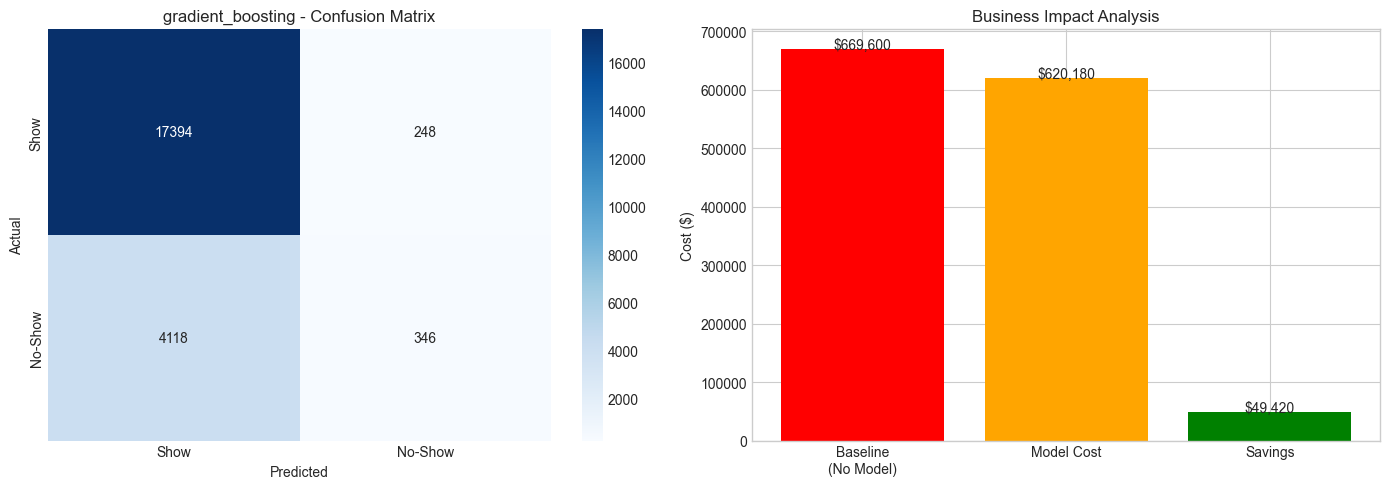

WEEK 5 SUMMARY: BASELINE MODELS

📊 Best Model: gradient_boosting

📈 Performance Metrics:
  • ROC-AUC: 0.7399
  • Accuracy: 0.8025
  • Precision: 0.5825
  • Recall: 0.0775
  • F1 Score: 0.1368

💰 Business Impact:
  • Appointments in test set: 22,106
  • True No-Shows identified: 346
  • Missed No-Shows: 4118
  • Estimated prevented no-shows: 103
  • Estimated net savings: $12,970

🔝 Top 5 Predictive Features:
  2. numeric__lead_days: 0.4663
  1. numeric__age: 0.1138
  18. categorical__lead_time_category_Same Day: 0.1047
  5. numeric__patient_historical_noshow_rate: 0.0768
  6. numeric__neighborhood_noshow_rate: 0.0421

NEXT STEPS (Week 6):

1. Hyperparameter tuning with GridSearchCV
2. Feature engineering based on importance analysis
3. Model interpretability with SHAP
4. Cross-validation strategy refinement
5. Threshold optimization for business objectives


✅ All artifacts saved!
  Models: ..\models\baseline
  Results: ..\outputs\experiments\20251201_161556


In [1]:
# %% [markdown]
"""
# Week 5: Baseline ML Models for No-Show Prediction

## Learning Objectives
- Frame ML problems for business applications
- Split data with stratification
- Train baseline classification models
- Evaluate models with appropriate metrics
- Compare models and select the best

## Business Context
We're building on our Month 1 analysis to create ML models that predict
which patients are likely to miss their appointments (no-show).

**Key Business Questions:**
1. Which patients should we prioritize for intervention?
2. How accurately can we predict no-shows?
3. What is the potential business impact of accurate predictions?
"""

# %% [markdown]
"""
## 1. Setup and Data Loading
"""

# %%
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent))

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, precision_recall_curve
)

# Our modules
from src.ml.preprocessing import NoShowPreprocessor
from src.ml.train import ModelTrainer
from src.ml.evaluate import ModelEvaluator

import yaml

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 50)

print("✅ All imports successful!")

# %%
# Load configuration
with open('../config/ml_config.yaml', 'r') as f:
    ml_config = yaml.safe_load(f)

print("ML Configuration loaded!")
print(f"Target column: {ml_config['ml_project']['target_column']}")
print(f"Primary metric: {ml_config['evaluation']['primary_metric']}")

# %%
# Load processed data from Month 1
data_path = '../data/processed/appointments_features.csv'
df = pd.read_csv(data_path)

print(f"Data shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['no_show'].value_counts(normalize=True).round(3))

# %% [markdown]
"""
## 2. Data Exploration for ML

Before training models, let's understand our data from an ML perspective.
"""

# %%
# Check for our target variable and key features
print("=" * 50)
print("TARGET VARIABLE ANALYSIS")
print("=" * 50)

target_col = 'no_show'
print(f"\nTarget: {target_col}")
print(f"Class distribution:")
print(df[target_col].value_counts())
print(f"\nClass imbalance ratio: 1:{(1 - df[target_col].mean()) / df[target_col].mean():.1f}")

# %%
# Check available features
print("=" * 50)
print("FEATURE AVAILABILITY CHECK")
print("=" * 50)

feature_config = ml_config['features']

# Check numeric features
numeric_available = [f for f in feature_config['numeric'] if f.lower() in [c.lower() for c in df.columns]]
print(f"\nNumeric features: {len(numeric_available)}/{len(feature_config['numeric'])}")
print(f"  Available: {numeric_available}")

# Check categorical features  
categorical_available = [f for f in feature_config['categorical'] if f.lower() in [c.lower() for c in df.columns]]
print(f"\nCategorical features: {len(categorical_available)}/{len(feature_config['categorical'])}")
print(f"  Available: {categorical_available}")

# Check binary features
binary_available = [f for f in feature_config['binary'] if f.lower() in [c.lower() for c in df.columns]]
print(f"\nBinary features: {len(binary_available)}/{len(feature_config['binary'])}")
print(f"  Available: {binary_available}")

# %% [markdown]
"""
## 3. Data Preprocessing

We'll use our `NoShowPreprocessor` class to:
1. Select features based on configuration
2. Split into train/test sets with stratification
3. Build sklearn preprocessing pipeline
"""

# %%
# Initialize preprocessor
preprocessor = NoShowPreprocessor(ml_config)

# Prepare data (select features and split)
X_train, X_test, y_train, y_test = preprocessor.prepare_data(df)

print(f"\n📊 Data Split Summary:")
print(f"  Training samples: {len(X_train):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Features: {X_train.shape[1]}")

# %%
# Fit and transform training data
X_train_transformed = preprocessor.fit_transform(X_train, y_train)
X_test_transformed = preprocessor.transform(X_test)

print(f"\n🔄 After Preprocessing:")
print(f"  Training shape: {X_train_transformed.shape}")
print(f"  Test shape: {X_test_transformed.shape}")
print(f"  Number of features: {len(preprocessor.feature_names_)}")

# %%
# Show some transformed feature names
print("\n📋 Sample Feature Names (after encoding):")
for i, name in enumerate(preprocessor.feature_names_[:15]):
    print(f"  {i+1}. {name}")
if len(preprocessor.feature_names_) > 15:
    print(f"  ... and {len(preprocessor.feature_names_) - 15} more")

# %% [markdown]
"""
## 4. Train Baseline Models

Now we'll train several baseline models:
- **Logistic Regression**: Interpretable linear model
- **Decision Tree**: Simple non-linear model
- **Random Forest**: Ensemble of decision trees
- **Gradient Boosting**: Sequential ensemble method
- **XGBoost**: Optimized gradient boosting (if available)
"""

# %%
# Initialize trainer
trainer = ModelTrainer(ml_config)

# Train all baseline models with cross-validation
models = trainer.train_baseline_models(X_train_transformed, y_train)

# %%
# Compare models based on cross-validation
comparison = trainer.compare_models()
print("\n📊 Model Comparison (Cross-Validation Results):")
print(comparison.to_string(index=False))

# %% [markdown]
"""
## 5. Evaluate on Test Set

Now let's evaluate our trained models on the held-out test set.
"""

# %%
# Initialize evaluator
evaluator = ModelEvaluator(ml_config)

# Evaluate all models on test set
results = evaluator.evaluate_all(models, X_test_transformed, y_test)

# %%
# Get comparison table
eval_table = evaluator.get_comparison_table()
print("\n📊 Test Set Performance:")
print(eval_table.to_string(index=False))

# %%
# Visualize ROC curves
fig = evaluator.plot_roc_curves(save=False)
plt.show()

# %%
# Visualize Precision-Recall curves
fig = evaluator.plot_precision_recall_curves(save=False)
plt.show()

# %%
# Visualize confusion matrices
fig = evaluator.plot_confusion_matrices(save=False)
plt.show()

# %%
# Metrics comparison bar chart
fig = evaluator.plot_metrics_comparison(save=False)
plt.show()

# %% [markdown]
"""
## 6. Feature Importance Analysis

Understanding which features are most predictive helps with:
- Model interpretability
- Feature engineering insights
- Business understanding
"""

# %%
# Get best model
best_name, best_model = trainer.get_best_model()
print(f"Best model: {best_name}")

# Get feature importance
importance_df = trainer.get_feature_importance(best_name, preprocessor.feature_names_)

# Plot top 20 features
fig = evaluator.plot_feature_importance(importance_df, best_name, top_n=20, save=False)
plt.show()

# %%
# Print top 10 features
print(f"\n🔝 Top 10 Most Important Features ({best_name}):")
print(importance_df.head(10).to_string(index=False))

# %% [markdown]
"""
## 7. Business Impact Analysis

Let's translate our model performance into business terms.
"""

# %%
# Calculate business impact
y_pred = best_model.predict(X_test_transformed)
impact = evaluator.calculate_business_impact(y_test.values, y_pred, best_name)

# %%
# Visualize business impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix with business context
ax1 = axes[0]
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Show', 'No-Show'],
            yticklabels=['Show', 'No-Show'])
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title(f'{best_name} - Confusion Matrix')

# Cost comparison
ax2 = axes[1]
costs = [
    ('Baseline\n(No Model)', impact['baseline_cost']),
    ('Model Cost', impact['model_cost']),
    ('Savings', impact['gross_savings'])
]
ax2.bar([c[0] for c in costs], [c[1] for c in costs], 
        color=['red', 'orange', 'green'])
ax2.set_ylabel('Cost ($)')
ax2.set_title('Business Impact Analysis')
for i, (_, val) in enumerate(costs):
    ax2.text(i, val + 500, f'${val:,.0f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# %% [markdown]
"""
## 8. Summary and Next Steps

### Key Findings:
"""

# %%
# Print summary
print("=" * 60)
print("WEEK 5 SUMMARY: BASELINE MODELS")
print("=" * 60)

print(f"\n📊 Best Model: {best_name}")
best_result = results[best_name]
print(f"\n📈 Performance Metrics:")
print(f"  • ROC-AUC: {best_result.roc_auc:.4f}")
print(f"  • Accuracy: {best_result.accuracy:.4f}")
print(f"  • Precision: {best_result.precision:.4f}")
print(f"  • Recall: {best_result.recall:.4f}")
print(f"  • F1 Score: {best_result.f1:.4f}")

print(f"\n💰 Business Impact:")
print(f"  • Appointments in test set: {len(y_test):,}")
print(f"  • True No-Shows identified: {impact['true_positives']}")
print(f"  • Missed No-Shows: {impact['false_negatives']}")
print(f"  • Estimated prevented no-shows: {impact['prevented_noshows']}")
print(f"  • Estimated net savings: ${impact['net_savings']:,.0f}")

print("\n🔝 Top 5 Predictive Features:")
for i, row in importance_df.head(5).iterrows():
    print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")

print("\n" + "=" * 60)
print("NEXT STEPS (Week 6):")
print("=" * 60)
print("""
1. Hyperparameter tuning with GridSearchCV
2. Feature engineering based on importance analysis
3. Model interpretability with SHAP
4. Cross-validation strategy refinement
5. Threshold optimization for business objectives
""")

# %%
# Save models and results
output_dir = Path('../models/baseline')
output_dir.mkdir(parents=True, exist_ok=True)

# Save preprocessor
preprocessor.save(output_dir / 'preprocessor.joblib')

# Save models
trainer.save_models(output_dir)

# Save evaluation results
results_dir = Path('../outputs/experiments') / trainer.experiment_id
evaluator.save_results(results_dir)

print(f"\n✅ All artifacts saved!")
print(f"  Models: {output_dir}")
print(f"  Results: {results_dir}")